In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image
import skimage
from matplotlib import pyplot as plt
from tqdm import tqdm
import cv2
import torch
import pickle
import glob
from skimage.color import label2rgb

import warnings
warnings.filterwarnings('ignore', message='overflow encountered in exp')

In [2]:
# https://stackoverflow.com/questions/66595055/fastest-way-of-computing-binary-mask-iou-with-numpy
def iou(mask1, mask2):
    intersection = (mask1 * mask2).sum()
    if intersection == 0:
        return 0.0
    union = torch.logical_or(mask1, mask2).to(torch.int).sum()
    return intersection / union

In [3]:
np.random.seed(0)

image_numbers = glob.glob("data/cityscapes/val_200/*_leftImg8bit.png")
image_numbers = [image_number[24:-16] for image_number in image_numbers]
image_numbers = np.random.permutation(image_numbers)
image_numbers_calibration = image_numbers[:100]
image_numbers_test = image_numbers[100:]

In [4]:
torch.__version__

'2.8.0+cu126'

In [5]:
torch.cuda.is_available()

True

In [6]:
from segment_anything import sam_model_registry, SamPredictor

def sigmoid(z):
    return 1/(1 + np.exp(-z))

sam_checkpoint = "models/segment_anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
device = "cuda"
sam.to(device=device)
predictor = SamPredictor(sam)

def segment_anything_predict(img, input_point):
    predictor.set_image(img)
    masks, scores, _ = predictor.predict(
        point_coords=input_point,
        point_labels=np.array([1]), # point is inside the object
        multimask_output=True,
        return_logits=True
    )
    masks = sigmoid(masks)
    return masks, scores

In [7]:
import itertools
def compute_pair_to_iou_dict(masks):
    indices = np.arange(len(masks))
    pairs = itertools.combinations(indices, 2)
    pair_to_iou = {}
    for pair in pairs:
        i, j = pair
        pair_to_iou[tuple(pair)] = iou(masks[i], masks[j]).numpy()
    return pair_to_iou

def remove_duplicate_masks(indices, pair_to_iou, iou_threshold=0.95):
    for k in np.arange(1, len(indices)+1):
        for new_indices in itertools.combinations(indices, k):
            removed_indices = list(set(indices) - set(new_indices))
            valid_combination = True
            for i in removed_indices:
                new_indices_contain_similar_mask = False
                for j in new_indices:
                    if pair_to_iou[tuple(sorted((i, j)))] > iou_threshold:
                        new_indices_contain_similar_mask = True
                        break
                if not new_indices_contain_similar_mask:
                    valid_combination = False
                    break
            if valid_combination:
                return list(new_indices)

# Calibrate conformal algorithm

In [9]:
np.random.seed(0)

points_per_image = 20
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers_calibration):
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    true_class_labels = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_labelIds.png'), cv2.IMREAD_UNCHANGED)
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        #if true_class_labels[x, y] == 24: # person
        if true_class_labels[x, y] == 26: # car
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for coord in coords:
            IOUs_coord = []
            true_shape = true_segmentation==true_segmentation[coord]
            masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
            masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
            for T1 in [0, 1, 2]:
                for T2 in np.arange(0.05, 0.96, 0.05):
                    pred_shape = masks_ordered[T1]>T2
                    IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape))
                    IOUs_coord.append(IOU)
            IOUs.append(IOUs_coord)
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).tolist())

  2%|███▏                                                                                                                                                              | 2/100 [00:00<00:20,  4.83it/s]/tmp/ipykernel_2341/1372101541.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [22:30<00:00, 13.51s/it]


In [10]:
results_table = pd.DataFrame.from_dict(results)
results_table

image_number        coord  \
0       lindau_000028_000019   (442, 633)   
1    frankfurt_000000_003357  (525, 1405)   
2      munster_000001_000019   (732, 256)   
3      munster_000069_000019  (550, 1596)   
4      munster_000069_000019   (679, 400)   
..                       ...          ...   
100    munster_000166_000019  (768, 2026)   
101    munster_000126_000019  (468, 1266)   
102  frankfurt_000001_068772   (547, 516)   
103     lindau_000034_000019   (618, 153)   
104     lindau_000034_000019    (730, 76)   

                                                  IOUs  
0    [0.05377494543790817, 0.053612131625413895, 0....  
1    [0.9807356595993042, 0.9797700643539429, 0.978...  
2    [0.943061888217926, 0.9441136717796326, 0.9443...  
3    [0.919996976852417, 0.9154890179634094, 0.9129...  
4    [0.9642695784568787, 0.9624242782592773, 0.960...  
..                                                 ...  
100  [0.8399352431297302, 0.8365952968597412, 0.834...  
101  [0.8856975436210632, 0.8807985782623291, 0.878...  
102  [0.967158854007721, 0.9636041522026062, 0.9607...  
103  [0.9309207797050476, 0.9266582131385803, 0.924...  
104  [0.9265952110290527, 0.922856867313385, 0.9203...  

[105 rows x 3 columns]

In [14]:
file = open('data/cityscapes/conformal_ious_SAM.pkl', 'wb')
pickle.dump(results_table, file)
file.close()

# Compute conformal confidence interval for threshold T

In [7]:
file = open('data/cityscapes/conformal_ious_SAM.pkl', 'rb')
results_table = pickle.load(file)
file.close()

In [8]:
IOU_threshold = 0.8
T_values = []
for T1 in [0, 1, 2]:
    for T2 in np.arange(5, 96, 5):
        T_values.append(100*T1 + T2)
T_values = np.array(T_values)

def compute_Ts_with_high_IOU(IOUs):
    indices_with_high_IOU = np.argwhere(np.array(IOUs) >= IOU_threshold)[:, 0]
    return T_values[indices_with_high_IOU]

def find_T_min(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_min = Ts_with_high_IOU[0]
        return T_min
    
def find_T_max(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_max = Ts_with_high_IOU[-1]
        return T_max
    
def find_T_median(Ts_with_high_IOU):
    if len(Ts_with_high_IOU) == 0:
        return np.nan
    else:
        T_median = np.percentile(Ts_with_high_IOU, 50, interpolation='lower')
        return T_median

results_table["max IOU"] = results_table["IOUs"].map(lambda x: np.max(x))
results_table["Ts with high IOU"] = results_table["IOUs"].map(compute_Ts_with_high_IOU)
results_table["T min"] = results_table["Ts with high IOU"].map(find_T_min)
results_table["T max"] = results_table["Ts with high IOU"].map(find_T_max)
results_table["T median"] = results_table["Ts with high IOU"].map(find_T_median)
results_table

image_number        coord  \
0       lindau_000028_000019   (442, 633)   
1    frankfurt_000000_003357  (525, 1405)   
2      munster_000001_000019   (732, 256)   
3      munster_000069_000019  (550, 1596)   
4      munster_000069_000019   (679, 400)   
..                       ...          ...   
100    munster_000166_000019  (768, 2026)   
101    munster_000126_000019  (468, 1266)   
102  frankfurt_000001_068772   (547, 516)   
103     lindau_000034_000019   (618, 153)   
104     lindau_000034_000019    (730, 76)   

                                                  IOUs   max IOU  \
0    [0.05377494543790817, 0.053612131625413895, 0....  0.885971   
1    [0.9807356595993042, 0.9797700643539429, 0.978...  0.980736   
2    [0.943061888217926, 0.9441136717796326, 0.9443...  0.944348   
3    [0.919996976852417, 0.9154890179634094, 0.9129...  0.919997   
4    [0.9642695784568787, 0.9624242782592773, 0.960...  0.964270   
..                                                 ...       ...   
100  [0.8399352431297302, 0.8365952968597412, 0.834...  0.839935   
101  [0.8856975436210632, 0.8807985782623291, 0.878...  0.904237   
102  [0.967158854007721, 0.9636041522026062, 0.9607...  0.967159   
103  [0.9309207797050476, 0.9266582131385803, 0.924...  0.930921   
104  [0.9265952110290527, 0.922856867313385, 0.9203...  0.926595   

                                      Ts with high IOU  T min  T max  T median  
0    [205, 210, 215, 220, 225, 230, 235, 240, 245, ...  205.0  295.0     250.0  
1    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0  110.0      55.0  
2    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0   95.0      50.0  
3    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0   95.0      50.0  
4    [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0   95.0      50.0  
..                                                 ...    ...    ...       ...  
100  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0  290.0      95.0  
101  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0  195.0      95.0  
102  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0   95.0      50.0  
103  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0  195.0      95.0  
104  [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60...    5.0  195.0      95.0  

[105 rows x 8 columns]

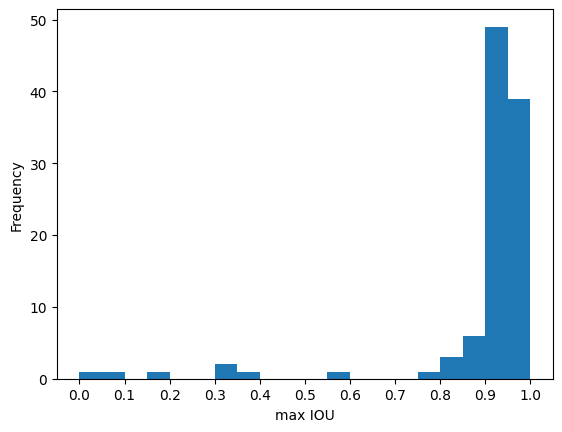

In [9]:
plt.hist(results_table["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

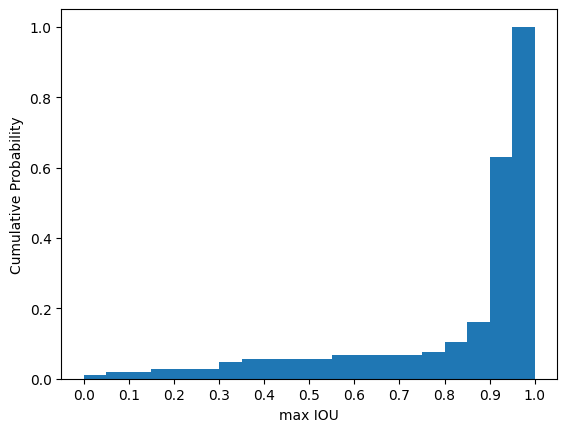

In [10]:
plt.hist(results_table["max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True)
plt.xlabel("max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

# Conformal using set cover greedy algorithm

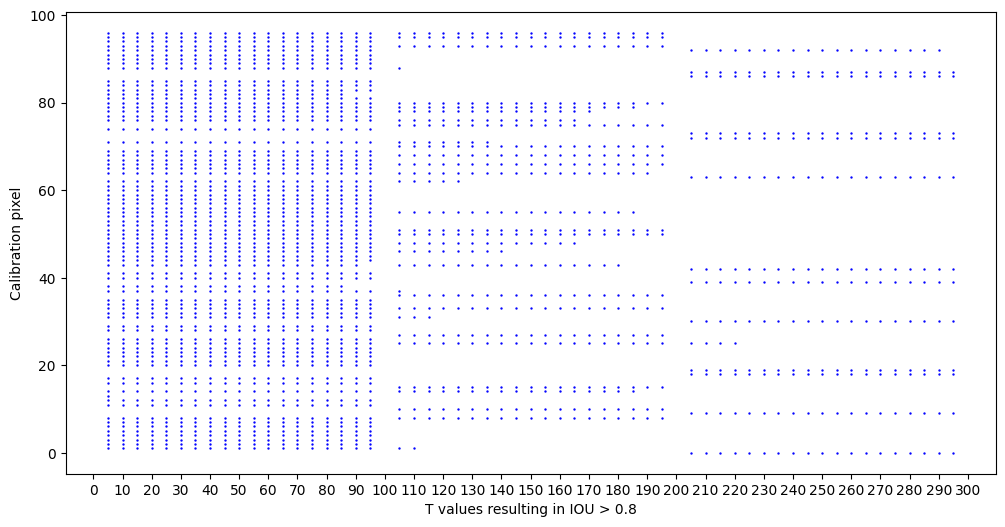

In [11]:
np.random.seed(0)

results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
#results_table_high_IOUs = results_table_high_IOUs.sample(n=100)
Ts_with_high_IOU = np.array(results_table_high_IOUs["Ts with high IOU"])

plt.figure(figsize=(12, 6))
for i in range(len(Ts_with_high_IOU)):
    xs = Ts_with_high_IOU[i]
    ys = np.repeat(i, len(xs))
    plt.scatter(xs, ys, color='blue', s=0.5)
    plt.xlabel(f"T values resulting in IOU > {IOU_threshold}")
    plt.ylabel("Calibration pixel")
    plt.xticks(np.arange(0, 301, 10))

In [12]:
alpha = .1
results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
p = 1 - len(results_table_high_IOUs) / len(results_table)
print(p)
if p > alpha:
    print("too uncertain")
else:
    IOUs = np.array([np.array(x) for x in results_table["IOUs"]])
    IOUs_high = (IOUs>IOU_threshold).astype(int)
    T_confidence_set = []
    num_calibration_pixels_covered = 0
    num_calibration_pixels_target = (1-alpha)*len(results_table)
    while num_calibration_pixels_covered < num_calibration_pixels_target:
        coverage_by_T = IOUs_high.sum(axis=0)
        best_T = np.argmax(coverage_by_T)
        calibration_pixels_covered = np.argwhere(IOUs_high[:, best_T]==1)
        IOUs_high = np.delete(IOUs_high, calibration_pixels_covered, axis=0)
        
        T_confidence_set.append(best_T)
        num_calibration_pixels_covered += np.max(coverage_by_T)

        print(T_values[best_T])
        print("Percent of calibration pixels covered so far:", num_calibration_pixels_covered/len(results_table))
    
    T_confidence_set = T_values[np.sort(T_confidence_set)]
    print(T_confidence_set)

0.07619047619047614
5
Percent of calibration pixels covered so far: 0.7523809523809524
205
Percent of calibration pixels covered so far: 0.8666666666666667
105
Percent of calibration pixels covered so far: 0.9238095238095239
[  5 105 205]


# Conformal using algorithm that returns minimal covering set of T values

In [16]:
import itertools
import math

alpha = .1
results_table_high_IOUs = results_table[results_table["max IOU"] > IOU_threshold]
p = 1 - len(results_table_high_IOUs) / len(results_table)
print(p)
if p > alpha:
    print("too uncertain")
else:
    IOUs = np.array([np.array(x) for x in results_table["IOUs"]])
    IOUs_high = (IOUs>IOU_threshold).astype(int)
    T_confidence_set = []
    num_calibration_pixels_covered = 0
    num_calibration_pixels_target = (1-alpha)*len(results_table)
    while num_calibration_pixels_covered < num_calibration_pixels_target:
        coverage_by_T = IOUs_high.sum(axis=0)
        best_T = np.argmax(coverage_by_T)
        calibration_pixels_covered = np.argwhere(IOUs_high[:, best_T]==1)
        IOUs_high = np.delete(IOUs_high, calibration_pixels_covered, axis=0)
        
        T_confidence_set.append(best_T)
        num_calibration_pixels_covered += np.max(coverage_by_T)

        print(T_values[best_T])
        print("Percent of calibration pixels covered so far:", num_calibration_pixels_covered/len(results_table))
    
    T_confidence_set = T_values[np.sort(T_confidence_set)]
    print("Greedy algorithm output:", T_confidence_set)

    IOUs_high = (IOUs>IOU_threshold).astype(int)
    n = IOUs_high.shape[1]
    indices = np.arange(n)
    m = len(T_confidence_set)
    for k in np.arange(2, m):
        print("Trying subsets of size", k)
        for indices_subset in tqdm(itertools.combinations(indices, k), total=math.comb(n,k)):
            IOUs_high_subset = IOUs_high[:, indices_subset]
            num_calibration_pixels_covered = (IOUs_high_subset.sum(axis=1) > 0).sum(axis=0)
            if num_calibration_pixels_covered >= num_calibration_pixels_target:
                T_confidence_set = np.sort(T_values[np.array(indices_subset)])
                break
        if num_calibration_pixels_covered >= num_calibration_pixels_target:
            break
                
    print("Final output:", T_confidence_set)

0.07619047619047614
5
Percent of calibration pixels covered so far: 0.7523809523809524
205
Percent of calibration pixels covered so far: 0.8666666666666667
105
Percent of calibration pixels covered so far: 0.9238095238095239
Greedy algorithm output: [  5 105 205]
Trying subsets of size 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1596/1596 [00:00<00:00, 29131.55it/s]

Final output: [  5 105 205]


# Investigate low IOUs

frankfurt_000001_001464
(365, 381)


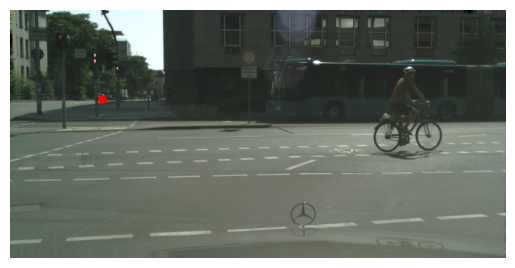

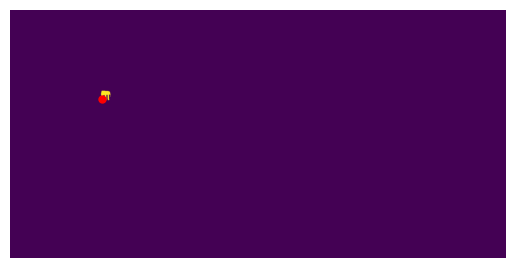

/tmp/ipykernel_4529/1372101541.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


SCORE: 0.6262526


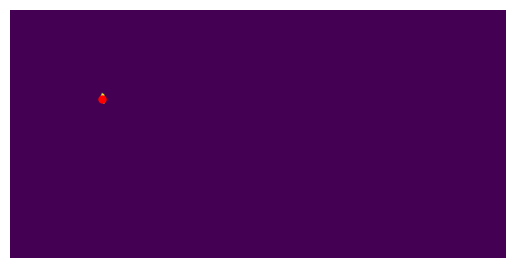

SCORE: 0.60037625


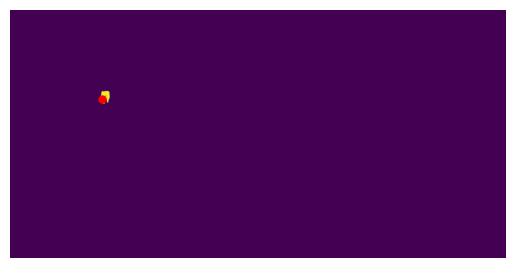

SCORE: 0.44658494


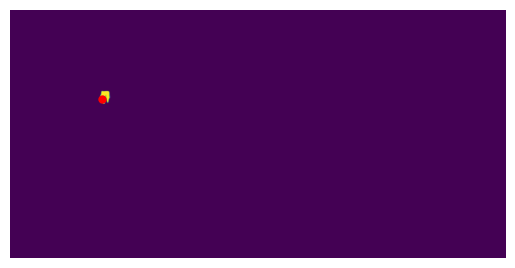

munster_000041_000019
(472, 759)


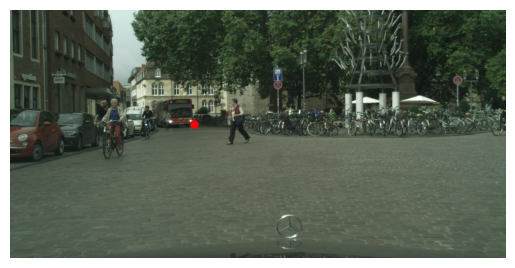

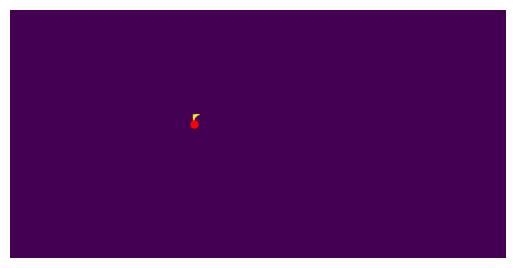

SCORE: 0.7095984


SCORE: 0.65190125


SCORE: 0.2747389


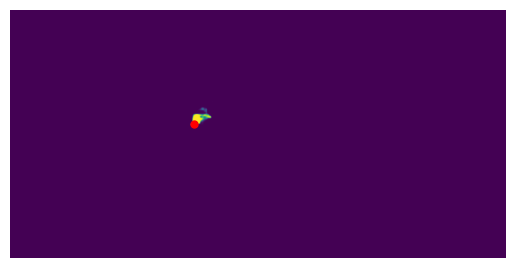

frankfurt_000001_058057
(370, 96)


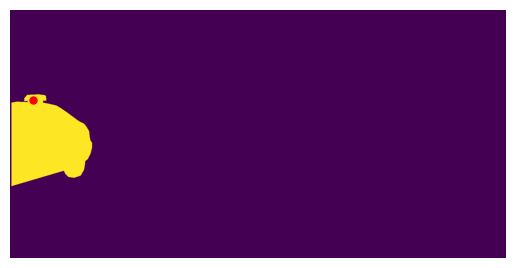

SCORE: 0.9563068


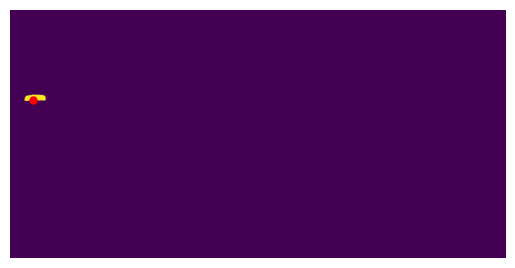

SCORE: 0.946061


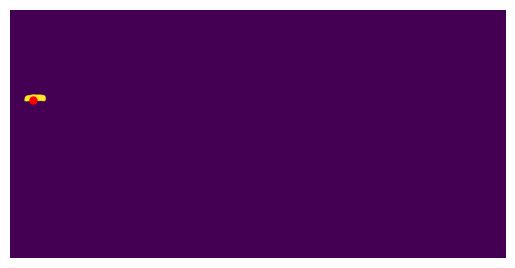

SCORE: 0.6520531


munster_000095_000019
(742, 273)


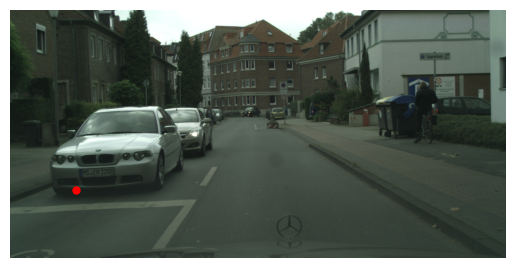

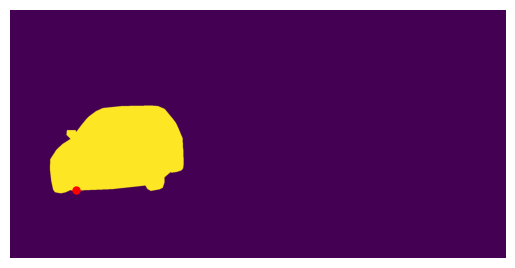

SCORE: 0.9113139


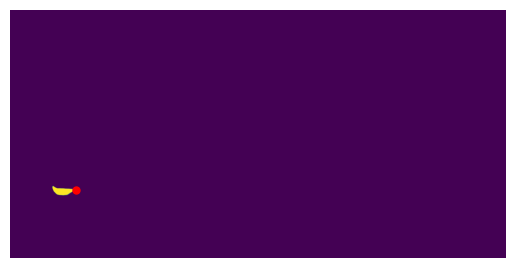

SCORE: 0.79118216


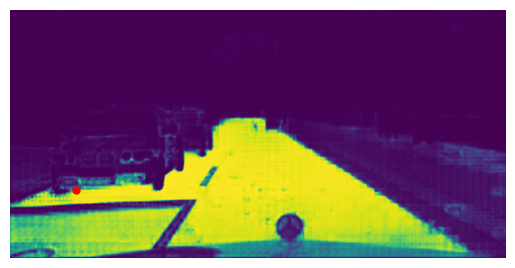

SCORE: 0.7158809


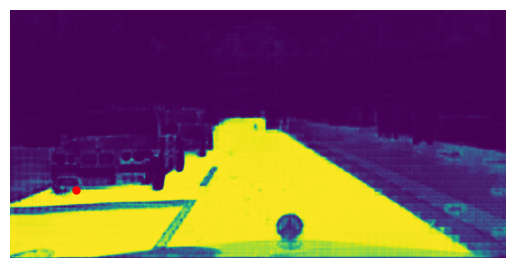

munster_000000_000019
(415, 632)


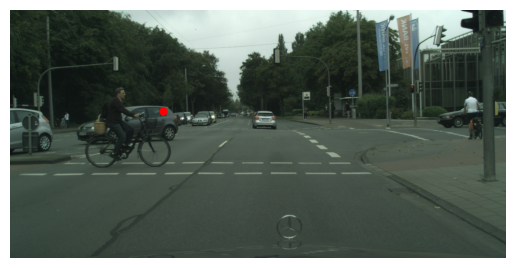

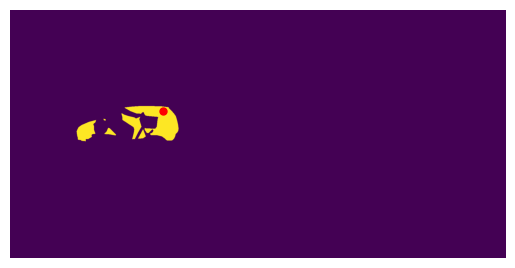

SCORE: 0.8418156


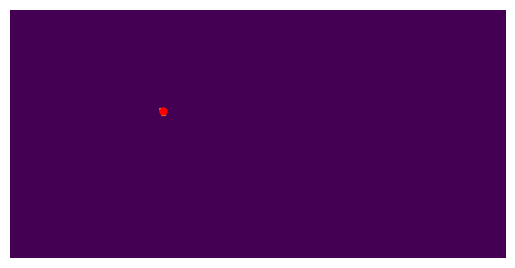

SCORE: 0.79104364


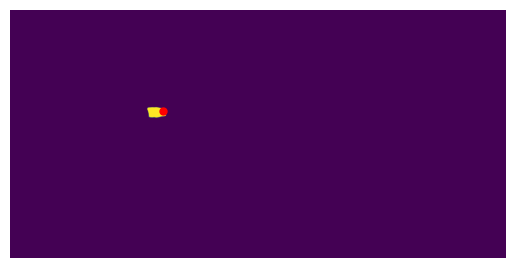

SCORE: 0.7603158


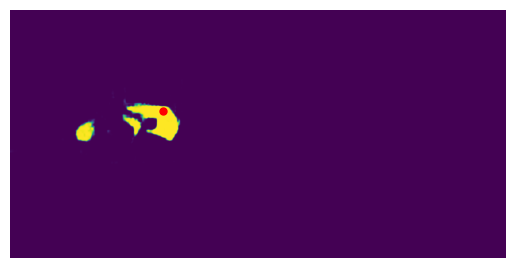

In [22]:
np.random.seed(0)

results_table_low_IOUs = results_table[results_table["max IOU"] < IOU_threshold]
for index, row in results_table_low_IOUs.sample(n=5).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    print(image_number)
    print(coord)
    
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(frameon=False) # initialize figure
    plt.axis('off')
    plt.imshow(img)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("True Segmentation")
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    plt.axis('off')
    plt.imshow(true_segmentation==true_segmentation[coord])
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("Predicted Segmentation (probabilities)")
    masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
    masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
    for i in range(len(masks_ordered)):
        print("SCORE:", np.sort(scores)[::-1][i])
        plt.axis('off')
        plt.imshow(masks[i])
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.show()

# Check conformal coverage on test set

In [20]:
np.random.seed(0)

points_per_image = 20
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers_test):
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    true_class_labels = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_labelIds.png'), cv2.IMREAD_UNCHANGED)
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        #if true_class_labels[x, y] == 24: # person
        if true_class_labels[x, y] == 26: # car
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for coord in coords:
            IOUs_coord = []
            true_shape = true_segmentation==true_segmentation[coord]
            masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
            masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
            for T in T_confidence_set:
                T1 = int(np.floor(T/100))
                T2 = (T % 100)/100
                pred_shape = masks_ordered[T1]>T2
                IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape))
                IOUs_coord.append(IOU)
            IOUs.append(IOUs_coord)
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).tolist())

  0%|                                                                                                                                                                          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_276/1372101541.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [24:18<00:00, 14.59s/it]


In [21]:
results_table_test = pd.DataFrame.from_dict(results)
results_table_test

image_number        coord  \
0      munster_000080_000019   (559, 551)   
1      munster_000080_000019  (707, 1701)   
2      munster_000080_000019  (754, 1940)   
3      munster_000080_000019  (472, 1733)   
4      munster_000080_000019  (396, 1871)   
..                       ...          ...   
116  frankfurt_000001_002759  (401, 1945)   
117     lindau_000016_000019  (516, 1318)   
118  frankfurt_000001_049770  (387, 1951)   
119    munster_000162_000019  (449, 1465)   
120    munster_000162_000019  (468, 1266)   

                                                  IOUs  
0    [0.9404219388961792, 0.9452168941497803, 0.368...  
1    [0.05915776267647743, 0.0580633170902729, 0.96...  
2    [0.9329650402069092, 0.40539535880088806, 0.30...  
3    [0.9761928915977478, 0.7747814059257507, 0.387...  
4    [0.1977183222770691, 0.032035380601882935, 0.9...  
..                                                 ...  
116  [0.9346731901168823, 0.7995210289955139, 0.898...  
117  [0.9421665072441101, 0.04578034579753876, 0.04...  
118  [0.05299380421638489, 0.3239947259426117, 0.20...  
119  [0.18929007649421692, 0.17590267956256866, 0.9...  
120  [0.9349722862243652, 0.18196216225624084, 0.07...  

[121 rows x 3 columns]

In [22]:
# Compute coverage
results_table_test["max IOU"] = results_table_test["IOUs"].map(lambda x: np.max(x))
results_table_test_high_IOUs = results_table_test[results_table_test["max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.8925619834710744


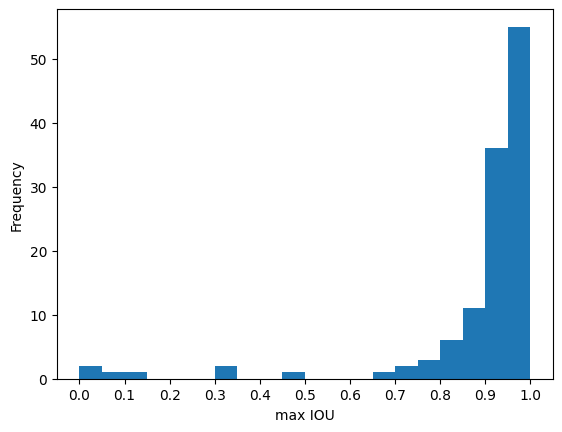

In [23]:
plt.hist(results_table_test["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [24]:
results_table_test

image_number        coord  \
0      munster_000080_000019   (559, 551)   
1      munster_000080_000019  (707, 1701)   
2      munster_000080_000019  (754, 1940)   
3      munster_000080_000019  (472, 1733)   
4      munster_000080_000019  (396, 1871)   
..                       ...          ...   
116  frankfurt_000001_002759  (401, 1945)   
117     lindau_000016_000019  (516, 1318)   
118  frankfurt_000001_049770  (387, 1951)   
119    munster_000162_000019  (449, 1465)   
120    munster_000162_000019  (468, 1266)   

                                                  IOUs   max IOU  
0    [0.9404219388961792, 0.9452168941497803, 0.368...  0.945217  
1    [0.05915776267647743, 0.0580633170902729, 0.96...  0.968105  
2    [0.9329650402069092, 0.40539535880088806, 0.30...  0.932965  
3    [0.9761928915977478, 0.7747814059257507, 0.387...  0.976193  
4    [0.1977183222770691, 0.032035380601882935, 0.9...  0.970486  
..                                                 ...       ...  
116  [0.9346731901168823, 0.7995210289955139, 0.898...  0.934673  
117  [0.9421665072441101, 0.04578034579753876, 0.04...  0.942167  
118  [0.05299380421638489, 0.3239947259426117, 0.20...  0.323995  
119  [0.18929007649421692, 0.17590267956256866, 0.9...  0.936707  
120  [0.9349722862243652, 0.18196216225624084, 0.07...  0.934972  

[121 rows x 4 columns]

In [25]:
file = open('data/cityscapes/conformal_ious_test_SAM.pkl', 'wb')
pickle.dump(results_table_test, file)
file.close()

frankfurt_000001_011162
(395, 1067)


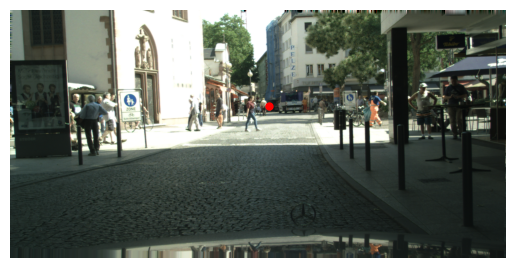

frankfurt_000001_014221
(474, 1323)


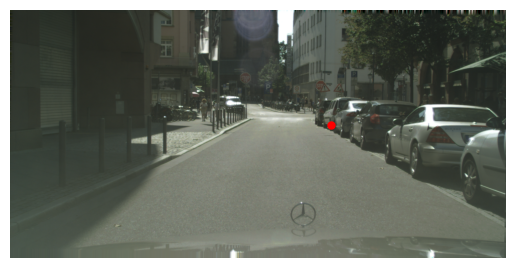

munster_000092_000019
(560, 1325)


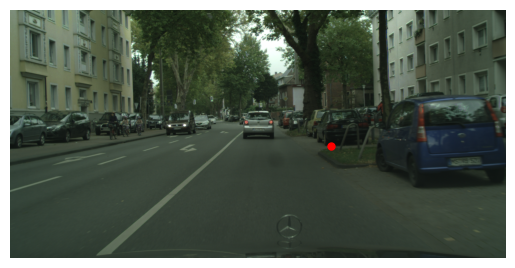

frankfurt_000001_054884
(476, 850)


munster_000092_000019
(456, 1202)


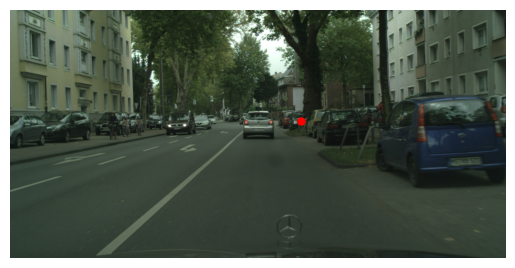

In [26]:
# Visualize low IOU test pixels

np.random.seed(0)

results_table_test_low_IOUs = results_table_test[results_table_test["max IOU"] < IOU_threshold]
for index, row in results_table_test_low_IOUs.sample(n=5).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    print(image_number)
    print(coord)
    
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(frameon=False) # initialize figure
    plt.axis('off')
    plt.imshow(img)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()

# Get segmentation confidence intervals for 5 test images

frankfurt_000001_064925
(449, 1875)


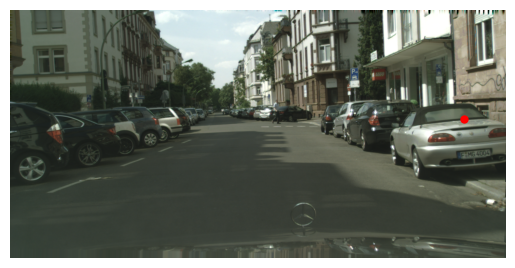

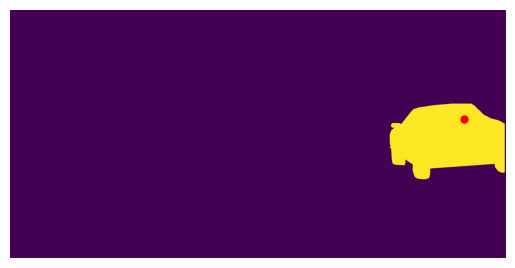

/tmp/ipykernel_276/1372101541.py:4: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


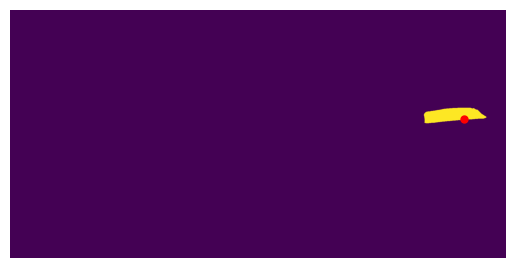

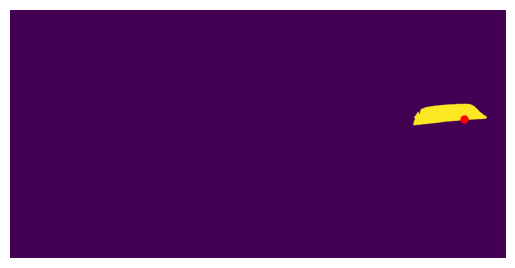

frankfurt_000001_060906
(580, 1291)


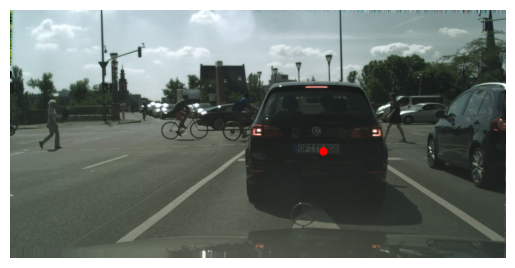

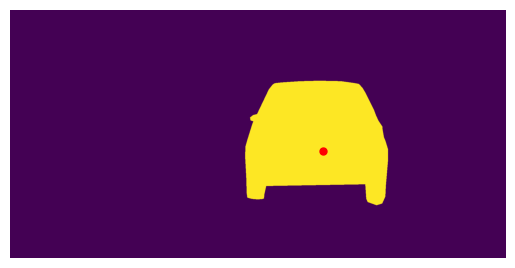

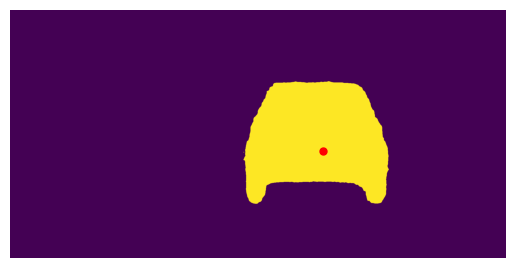

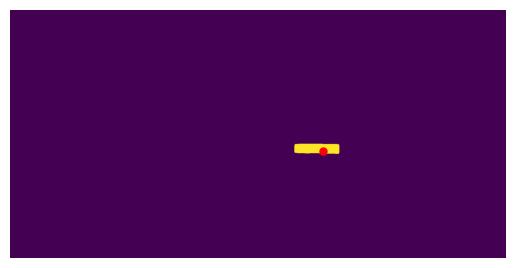

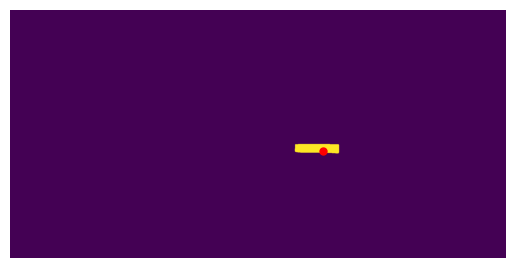

frankfurt_000001_060906
(544, 1782)


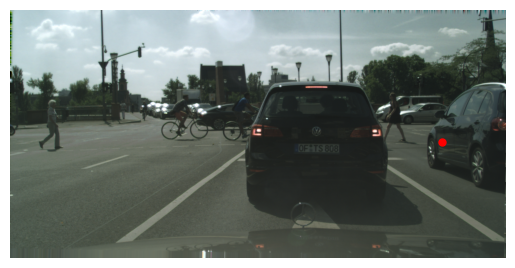

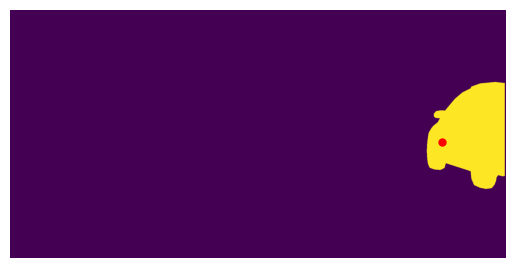

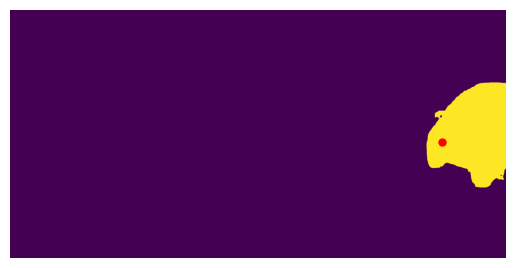

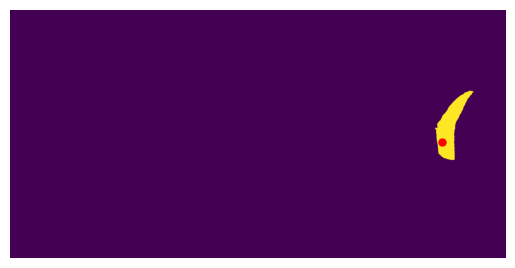

frankfurt_000000_000576
(606, 555)


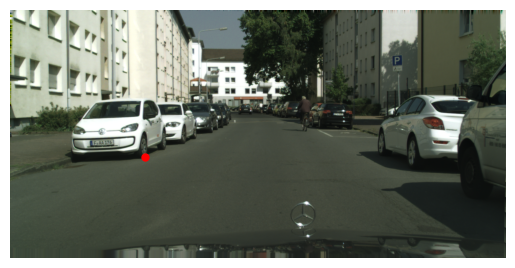

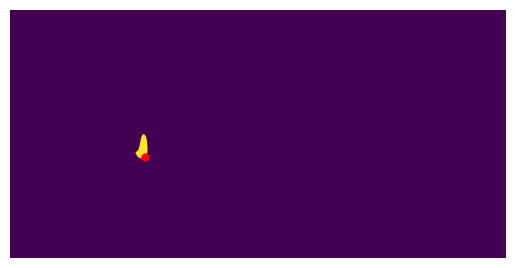

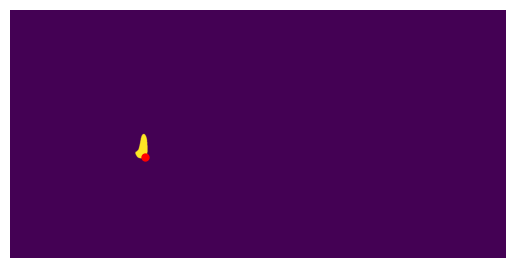

lindau_000041_000019
(468, 1735)


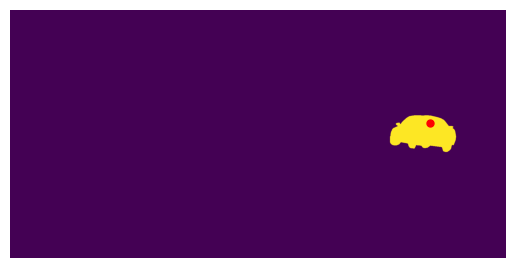

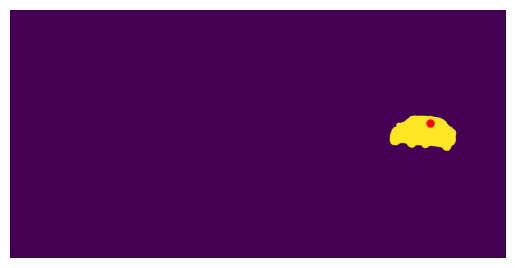

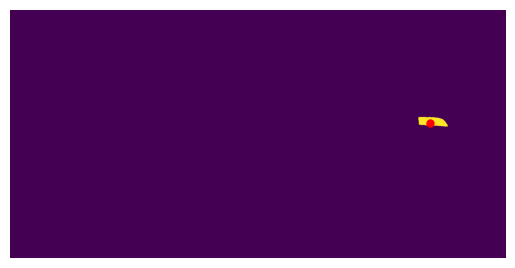

In [27]:
np.random.seed(0)

for index, row in results_table_test.sample(n=5).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    print(image_number)
    print(coord)
    
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(frameon=False) # initialize figure
    plt.axis('off')
    plt.imshow(img)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("True Segmentation")
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    plt.axis('off')
    plt.imshow(true_segmentation==true_segmentation[coord])
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("Confidence Set")
    masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
    masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
    for T in T_confidence_set:
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        pred_shape = masks_ordered[T1]>T2
        plt.axis('off')
        plt.imshow(pred_shape)
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.show()

# Remove duplicate predicted masks

In [67]:
np.random.seed(0)

points_per_image = 20
results = {"image_number": [], "coord": [], "IOUs": [], "Pred Mask Pair to IOUs": []}
for image_number in tqdm(image_numbers_test):
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    true_class_labels = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_labelIds.png'), cv2.IMREAD_UNCHANGED)
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        #if true_class_labels[x, y] == 24: # person
        if true_class_labels[x, y] == 26: # car
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    pair_to_iou_dicts = []
    if len(coords) != 0:
        for coord in coords:
            IOUs_coord = []
            pred_shapes_coord = []
            true_shape = true_segmentation==true_segmentation[coord]
            masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
            masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
            for T in T_confidence_set:
                T1 = int(np.floor(T/100))
                T2 = (T % 100)/100
                pred_shape = masks_ordered[T1]>T2
                IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape))
                pred_shapes_coord.append(torch.from_numpy(pred_shape))
                IOUs_coord.append(IOU)
            IOUs.append(IOUs_coord)
            pair_to_iou_dicts.append(compute_pair_to_iou_dict(pred_shapes_coord))
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).tolist())
    results["Pred Mask Pair to IOUs"].extend(pair_to_iou_dicts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [24:13<00:00, 14.54s/it]


In [68]:
results_table_test = pd.DataFrame.from_dict(results)
results_table_test

image_number        coord  \
0      munster_000080_000019   (559, 551)   
1      munster_000080_000019  (707, 1701)   
2      munster_000080_000019  (754, 1940)   
3      munster_000080_000019  (472, 1733)   
4      munster_000080_000019  (396, 1871)   
..                       ...          ...   
116  frankfurt_000001_002759  (401, 1945)   
117     lindau_000016_000019  (516, 1318)   
118  frankfurt_000001_049770  (387, 1951)   
119    munster_000162_000019  (449, 1465)   
120    munster_000162_000019  (468, 1266)   

                                                  IOUs  \
0    [0.9404219388961792, 0.9452168941497803, 0.368...   
1    [0.05915776267647743, 0.0580633170902729, 0.96...   
2    [0.9329650402069092, 0.40539535880088806, 0.30...   
3    [0.9761928915977478, 0.7747814059257507, 0.387...   
4    [0.1977183222770691, 0.032035380601882935, 0.9...   
..                                                 ...   
116  [0.9346731901168823, 0.7995210289955139, 0.898...   
117  [0.9421665072441101, 0.04578034579753876, 0.04...   
118  [0.05299380421638489, 0.3239947259426117, 0.20...   
119  [0.18929007649421692, 0.17590267956256866, 0.9...   
120  [0.9349722862243652, 0.18196216225624084, 0.07...   

                                Pred Mask Pair to IOUs  
0    {(0, 1): 0.96263236, (0, 2): 0.36985916, (1, 2...  
1    {(0, 1): 0.97748715, (0, 2): 0.058086187, (1, ...  
2    {(0, 1): 0.4088394, (0, 2): 0.3084815, (1, 2):...  
3    {(0, 1): 0.7902234, (0, 2): 0.38766852, (1, 2)...  
4    {(0, 1): 0.15872209, (0, 2): 0.20076765, (1, 2...  
..                                                 ...  
116  {(0, 1): 0.82462317, (0, 2): 0.95618194, (1, 2...  
117  {(0, 1): 0.043539163, (0, 2): 0.040966388, (1,...  
118  {(0, 1): 0.13005571, (0, 2): 0.033834208, (1, ...  
119  {(0, 1): 0.92927575, (0, 2): 0.1960536, (1, 2)...  
120  {(0, 1): 0.18296275, (0, 2): 0.07479499, (1, 2...  

[121 rows x 4 columns]

In [69]:
# Compute coverage
results_table_test["max IOU"] = results_table_test["IOUs"].map(lambda x: np.max(x))
results_table_test_high_IOUs = results_table_test[results_table_test["max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.8925619834710744


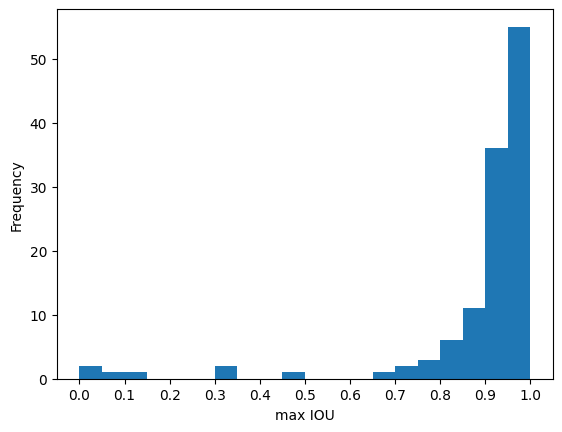

In [70]:
plt.hist(results_table_test["max IOU"], bins=np.arange(0, 1.01, .05))
plt.xlabel("max IOU")
plt.ylabel("Frequency")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [71]:
file = open('data/cityscapes/conformal_ious_test_SAM_with_pairwise_IOUs.pkl', 'wb')
pickle.dump(results_table_test, file)
file.close()

In [103]:
indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: np.max(x))

# Compute coverage after removing duplicate masks
p = IOU_threshold + IOU_threshold_duplicate_mask - 1
results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > p]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > IOU_threshold]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

plt.bar(results_table_test['Final Mask Number'].value_counts().index, results_table_test['Final Mask Number'].value_counts().values)
plt.xticks(np.arange(0, 4))
plt.xlabel("Number of Masks")
plt.ylabel("Frequency")
plt.show()

results_table_test

0.9256198347107438
0.8925619834710744


image_number        coord  \
0      munster_000080_000019   (559, 551)   
1      munster_000080_000019  (707, 1701)   
2      munster_000080_000019  (754, 1940)   
3      munster_000080_000019  (472, 1733)   
4      munster_000080_000019  (396, 1871)   
..                       ...          ...   
116  frankfurt_000001_002759  (401, 1945)   
117     lindau_000016_000019  (516, 1318)   
118  frankfurt_000001_049770  (387, 1951)   
119    munster_000162_000019  (449, 1465)   
120    munster_000162_000019  (468, 1266)   

                                                  IOUs  \
0    [0.9404219388961792, 0.9452168941497803, 0.368...   
1    [0.05915776267647743, 0.0580633170902729, 0.96...   
2    [0.9329650402069092, 0.40539535880088806, 0.30...   
3    [0.9761928915977478, 0.7747814059257507, 0.387...   
4    [0.1977183222770691, 0.032035380601882935, 0.9...   
..                                                 ...   
116  [0.9346731901168823, 0.7995210289955139, 0.898...   
117  [0.9421665072441101, 0.04578034579753876, 0.04...   
118  [0.05299380421638489, 0.3239947259426117, 0.20...   
119  [0.18929007649421692, 0.17590267956256866, 0.9...   
120  [0.9349722862243652, 0.18196216225624084, 0.07...   

                                Pred Mask Pair to IOUs   max IOU  \
0    {(0, 1): 0.96263236, (0, 2): 0.36985916, (1, 2...  0.945217   
1    {(0, 1): 0.97748715, (0, 2): 0.058086187, (1, ...  0.968105   
2    {(0, 1): 0.4088394, (0, 2): 0.3084815, (1, 2):...  0.932965   
3    {(0, 1): 0.7902234, (0, 2): 0.38766852, (1, 2)...  0.976193   
4    {(0, 1): 0.15872209, (0, 2): 0.20076765, (1, 2...  0.970486   
..                                                 ...       ...   
116  {(0, 1): 0.82462317, (0, 2): 0.95618194, (1, 2...  0.934673   
117  {(0, 1): 0.043539163, (0, 2): 0.040966388, (1,...  0.942167   
118  {(0, 1): 0.13005571, (0, 2): 0.033834208, (1, ...  0.323995   
119  {(0, 1): 0.92927575, (0, 2): 0.1960536, (1, 2)...  0.936707   
120  {(0, 1): 0.18296275, (0, 2): 0.07479499, (1, 2...  0.934972   

    Final Mask Indices  Final Mask Number  \
0               [0, 2]                  2   
1               [0, 2]                  2   
2            [0, 1, 2]                  3   
3            [0, 1, 2]                  3   
4            [0, 1, 2]                  3   
..                 ...                ...   
116             [0, 1]                  2   
117             [0, 1]                  2   
118          [0, 1, 2]                  3   
119             [0, 2]                  2   
120          [0, 1, 2]                  3   

                                       Final Mask IOUs  Final Mask max IOU  
0            [0.9404219388961792, 0.36861538887023926]            0.940422  
1            [0.05915776267647743, 0.9681052565574646]            0.968105  
2    [0.9329650402069092, 0.40539535880088806, 0.30...            0.932965  
3    [0.9761928915977478, 0.7747814059257507, 0.387...            0.976193  
4    [0.1977183222770691, 0.032035380601882935, 0.9...            0.970486  
..                                                 ...                 ...  
116           [0.9346731901168823, 0.7995210289955139]            0.934673  
117          [0.9421665072441101, 0.04578034579753876]            0.942167  
118  [0.05299380421638489, 0.3239947259426117, 0.20...            0.323995  
119          [0.18929007649421692, 0.9367072582244873]            0.936707  
120  [0.9349722862243652, 0.18196216225624084, 0.07...            0.934972  

[121 rows x 9 columns]

frankfurt_000001_064925
(449, 1875)


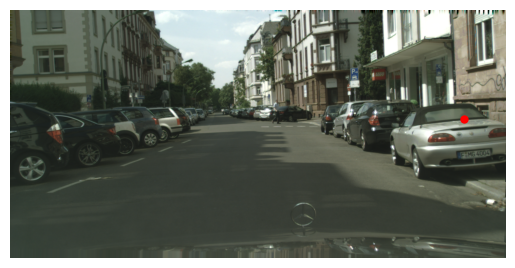

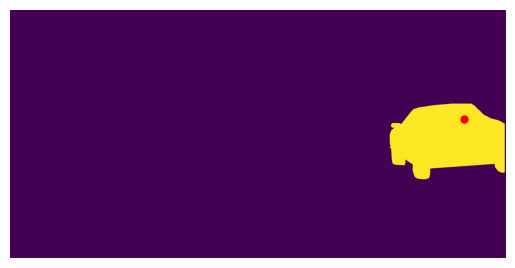

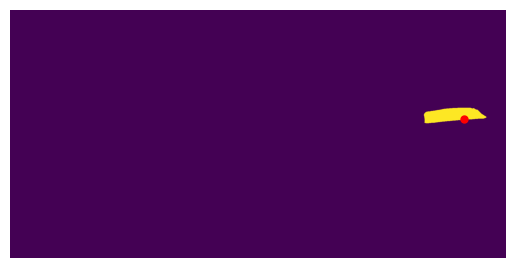

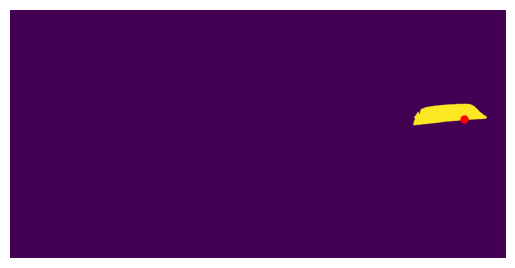

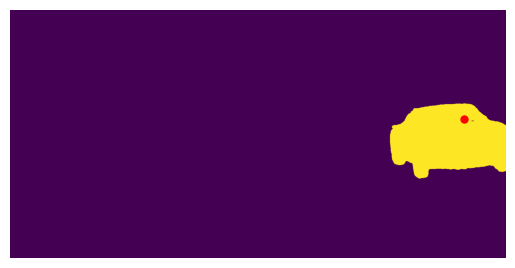

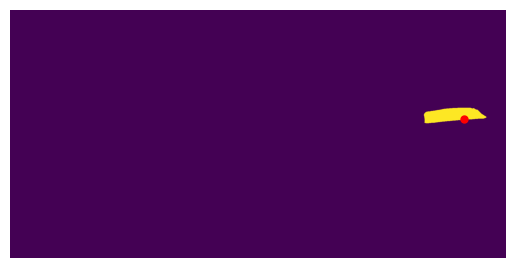

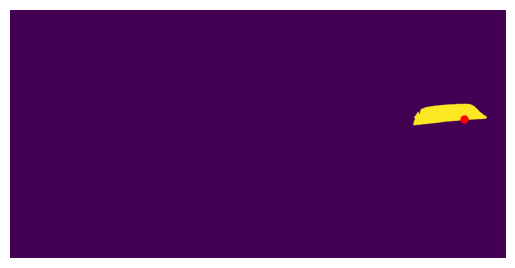

frankfurt_000001_060906
(580, 1291)


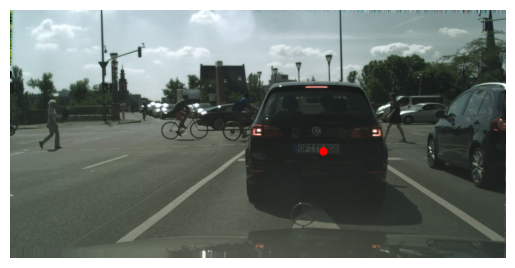

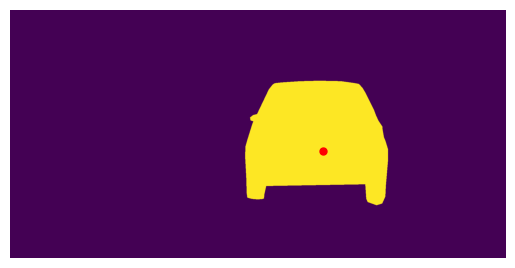

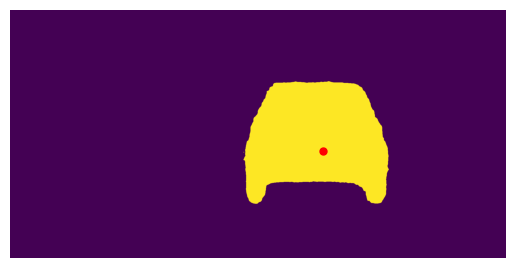

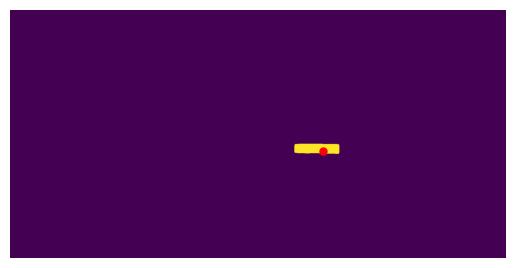

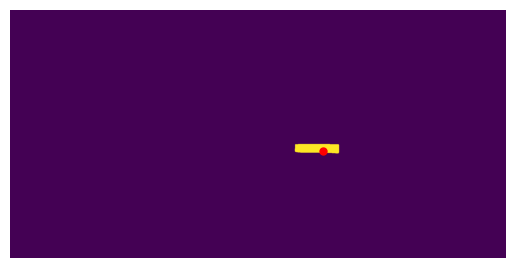

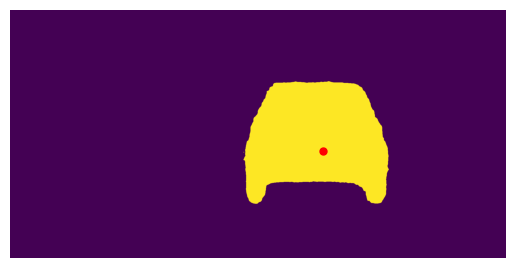

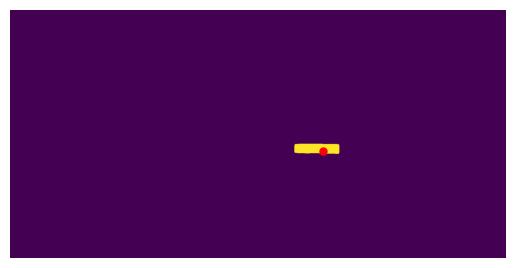

frankfurt_000001_060906
(544, 1782)


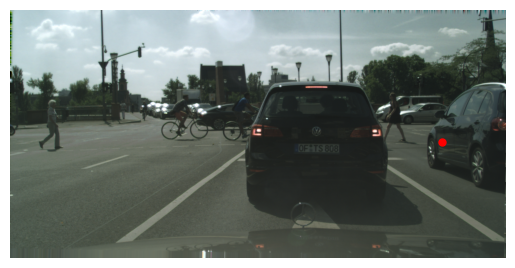

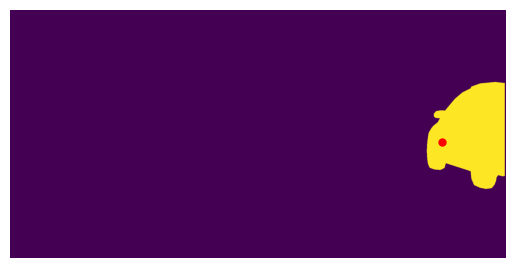

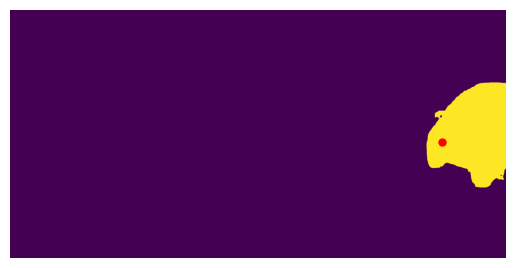

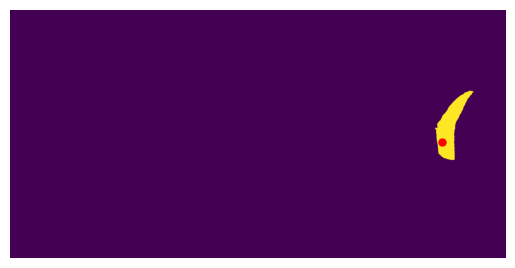

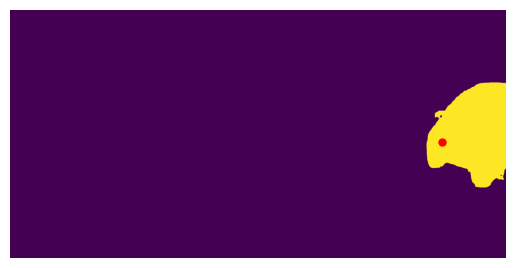

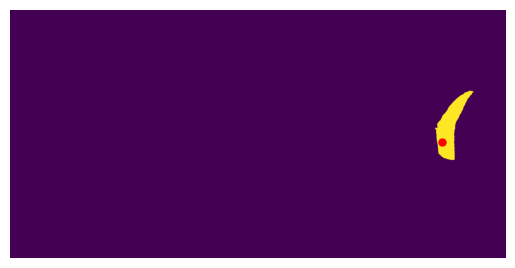

frankfurt_000000_000576
(606, 555)


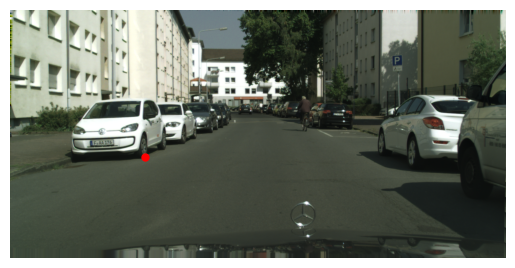

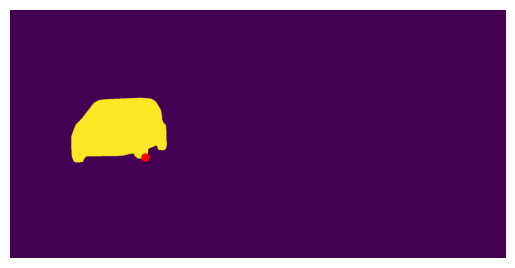

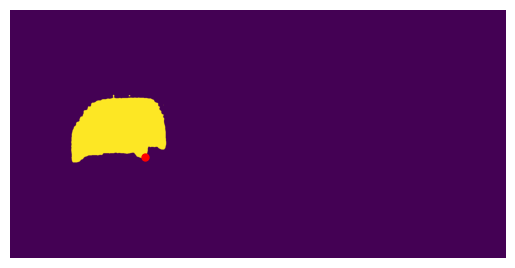

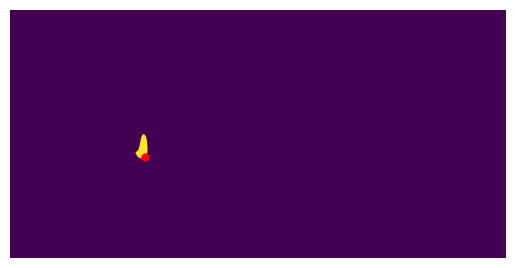

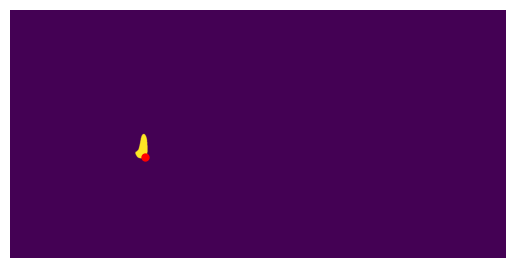

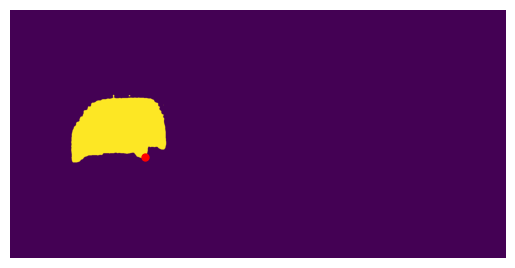

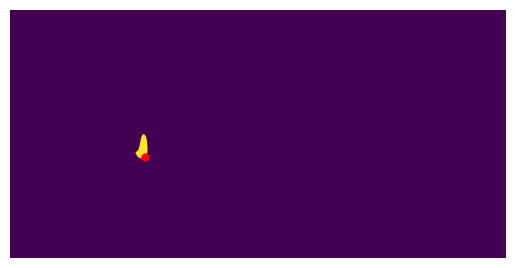

lindau_000041_000019
(468, 1735)


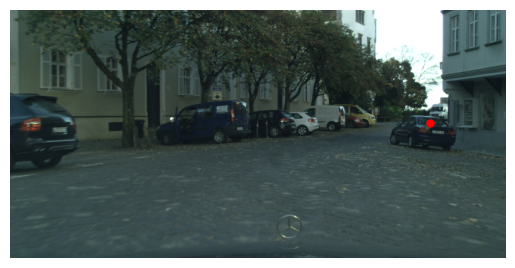

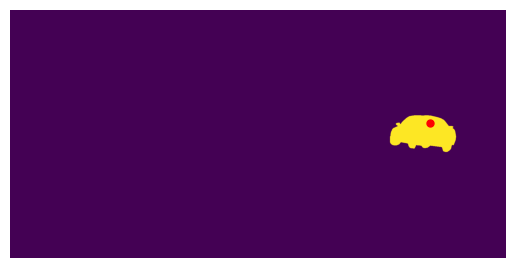

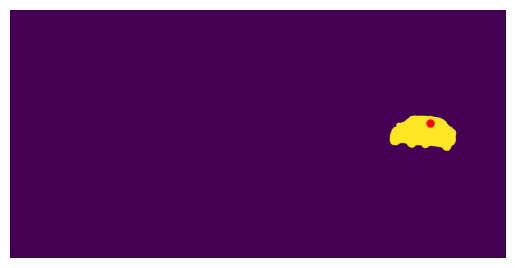

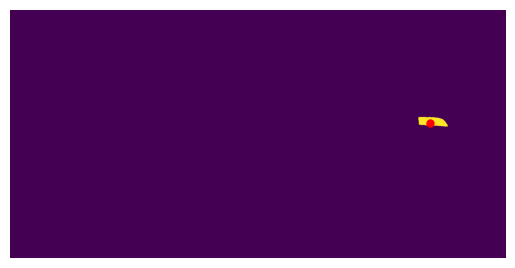

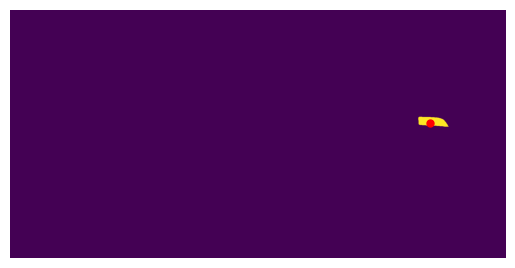

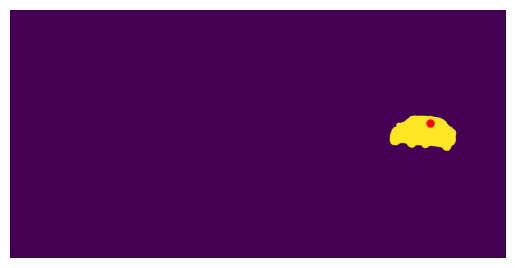

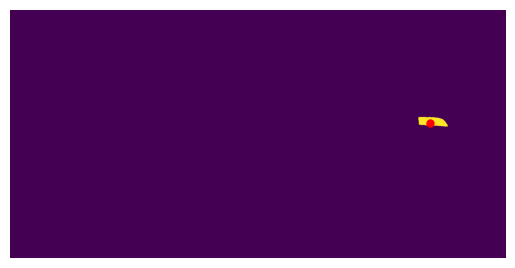

In [104]:
np.random.seed(0)

for index, row in results_table_test.sample(n=5).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    print(image_number)
    print(coord)
    
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig = plt.figure(frameon=False) # initialize figure
    plt.axis('off')
    plt.imshow(img)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("True Segmentation")
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    plt.axis('off')
    plt.imshow(true_segmentation==true_segmentation[coord])
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.show()
    
    #print("Confidence Set")
    masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
    masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
    for T in T_confidence_set:
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        pred_shape = masks_ordered[T1]>T2
        plt.axis('off')
        plt.imshow(pred_shape)
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.show()

    #print("Confidence Set with Duplicates Removed")
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    for T in T_confidence_set_duplicates_removed:
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        pred_shape = masks_ordered[T1]>T2
        plt.axis('off')
        plt.imshow(pred_shape)
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        plt.show()

In [105]:
file = open('data/cityscapes/conformal_ious_test_SAM_remove_duplicate_masks.pkl', 'wb')
pickle.dump(results_table_test, file)
file.close()

# Conformal calibration that includes removing duplicates

In [11]:
T_confidence_set = [5, 105, 205]

In [9]:
np.random.seed(0)

points_per_image = 20
results = {"image_number": [], "coord": [], "IOUs": [], "Pred Mask Pair to IOUs": []}
for image_number in tqdm(image_numbers_calibration):
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    true_class_labels = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_labelIds.png'), cv2.IMREAD_UNCHANGED)
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        #if true_class_labels[x, y] == 24: # person
        if true_class_labels[x, y] == 26: # car
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    pair_to_iou_dicts = []
    if len(coords) != 0:
        for coord in coords:
            IOUs_coord = []
            pred_shapes_coord = []
            true_shape = true_segmentation==true_segmentation[coord]
            masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
            masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
            for T in T_confidence_set:
                T1 = int(np.floor(T/100))
                T2 = (T % 100)/100
                pred_shape = masks_ordered[T1]>T2
                IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape))
                pred_shapes_coord.append(torch.from_numpy(pred_shape))
                IOUs_coord.append(IOU)
            IOUs.append(IOUs_coord)
            pair_to_iou_dicts.append(compute_pair_to_iou_dict(pred_shapes_coord))
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).tolist())
    results["Pred Mask Pair to IOUs"].extend(pair_to_iou_dicts)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [21:33<00:00, 12.94s/it]


In [10]:
results_table_calibration = pd.DataFrame.from_dict(results)

In [10]:
IOU_threshold = 0.8

results_table_calibration["max IOU"] = results_table_calibration["IOUs"].map(lambda x: np.max(x))
results_table_calibration_high_IOUs = results_table_calibration[results_table_calibration["max IOU"] > IOU_threshold]

coverage = len(results_table_calibration_high_IOUs) / len(results_table_calibration)
print(coverage)

alpha = 0.1

0.9238095238095239


In [12]:
indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_calibration["Final Mask Indices"] = results_table_calibration["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_calibration["Final Mask Number"] = results_table_calibration["Final Mask Indices"].apply(lambda x: len(x))
results_table_calibration["Final Mask IOUs"] = results_table_calibration.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_calibration["Final Mask max IOU"] = results_table_calibration["Final Mask IOUs"].map(lambda x: np.max(x))

results_table_calibration

image_number        coord  \
0       lindau_000028_000019   (442, 633)   
1    frankfurt_000000_003357  (525, 1405)   
2      munster_000001_000019   (732, 256)   
3      munster_000069_000019  (550, 1596)   
4      munster_000069_000019   (679, 400)   
..                       ...          ...   
100    munster_000166_000019  (768, 2026)   
101    munster_000126_000019  (468, 1266)   
102  frankfurt_000001_068772   (547, 516)   
103     lindau_000034_000019   (618, 153)   
104     lindau_000034_000019    (730, 76)   

                                                  IOUs  \
0    [0.05377494543790817, 0.05600781366229057, 0.8...   
1    [0.9807356595993042, 0.8781569600105286, 0.020...   
2    [0.943061888217926, 0.0562993586063385, 0.0764...   
3    [0.919996976852417, 0.10145225375890732, 0.058...   
4    [0.9642695784568787, 0.028456054627895355, 0.0...   
..                                                 ...   
100  [0.8399352431297302, 0.49383345246315, 0.83916...   
101  [0.8856975436210632, 0.898690938949585, 0.7440...   
102  [0.967158854007721, 0.058008044958114624, 0.00...   
103  [0.9309207797050476, 0.9246478080749512, 0.415...   
104  [0.9265952110290527, 0.9173616766929626, 0.149...   

                                Pred Mask Pair to IOUs   max IOU  \
0    {(0, 1): 0.9601329, (0, 2): 0.050420903, (1, 2...  0.881496   
1    {(0, 1): 0.8800499, (0, 2): 0.020832827, (1, 2...  0.980736   
2    {(0, 1): 0.058151934, (0, 2): 0.079160154, (1,...  0.943062   
3    {(0, 1): 0.12429034, (0, 2): 0.07990662, (1, 2...  0.919997   
4    {(0, 1): 0.02811726, (0, 2): 0.029106515, (1, ...  0.964270   
..                                                 ...       ...   
100  {(0, 1): 0.584388, (0, 2): 0.99415976, (1, 2):...  0.839935   
101  {(0, 1): 0.92882776, (0, 2): 0.8057508, (1, 2)...  0.898691   
102  {(0, 1): 0.05822473, (0, 2): 0.0016121913, (1,...  0.967159   
103  {(0, 1): 0.9787186, (0, 2): 0.44452843, (1, 2)...  0.930921   
104  {(0, 1): 0.9774635, (0, 2): 0.15947722, (1, 2)...  0.926595   

    Final Mask Indices  Final Mask Number  \
0               [0, 2]                  2   
1            [0, 1, 2]                  3   
2            [0, 1, 2]                  3   
3            [0, 1, 2]                  3   
4               [0, 1]                  2   
..                 ...                ...   
100             [0, 1]                  2   
101             [0, 2]                  2   
102          [0, 1, 2]                  3   
103             [0, 2]                  2   
104             [0, 2]                  2   

                                       Final Mask IOUs  Final Mask max IOU  
0            [0.05377494543790817, 0.8814958930015564]            0.881496  
1    [0.9807356595993042, 0.8781569600105286, 0.020...            0.980736  
2    [0.943061888217926, 0.0562993586063385, 0.0764...            0.943062  
3    [0.919996976852417, 0.10145225375890732, 0.058...            0.919997  
4           [0.9642695784568787, 0.028456054627895355]            0.964270  
..                                                 ...                 ...  
100             [0.8399352431297302, 0.49383345246315]            0.839935  
101           [0.8856975436210632, 0.7440617680549622]            0.885698  
102  [0.967158854007721, 0.058008044958114624, 0.00...            0.967159  
103           [0.9309207797050476, 0.4156823754310608]            0.930921  
104          [0.9265952110290527, 0.14929670095443726]            0.926595  

[105 rows x 9 columns]

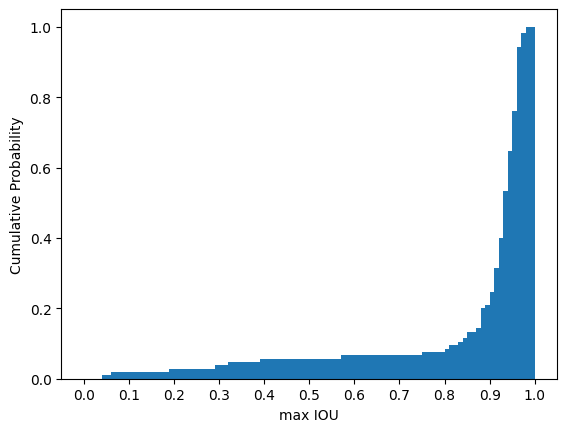

In [13]:
plt.hist(results_table_calibration["max IOU"], bins=np.arange(0, 1.01, .01), density=True, cumulative=True)
plt.xlabel("max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

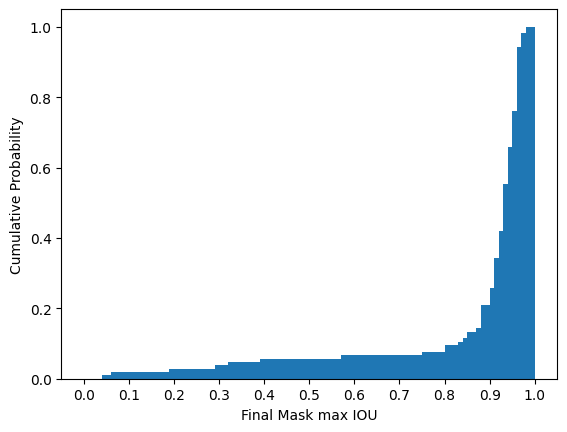

In [14]:
plt.hist(results_table_calibration["Final Mask max IOU"], bins=np.arange(0, 1.01, .01), density=True, cumulative=True)
plt.xlabel("Final Mask max IOU")
plt.ylabel("Cumulative Probability")
plt.xticks(np.arange(0, 1.01, 0.1))
plt.show()

In [15]:
q = np.quantile(results_table_calibration["Final Mask max IOU"], alpha)
print(q)

0.8424226880073548


In [16]:
file = open('data/cityscapes/conformal_ious_calibration_SAM_remove_duplicate_masks.pkl', 'wb')
pickle.dump(results_table_calibration, file)
file.close()

In [17]:
# check coverage on test set
file = open('data/cityscapes/conformal_ious_test_SAM_remove_duplicate_masks.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

In [20]:
indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: np.max(x))

# Compute coverage after removing duplicate masks
results_table_test_high_IOUs = results_table_test[results_table_test["Final Mask max IOU"] > q]
coverage = len(results_table_test_high_IOUs) / len(results_table_test)
print(coverage)

0.8429752066115702


# Compare test coverage using baseline model (mask with top confidence score and threshold=0.5)

In [21]:
np.random.seed(0)

points_per_image = 20
results = {"image_number": [], "coord": [], "IOUs": []}
for image_number in tqdm(image_numbers_test):
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    true_class_labels = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_labelIds.png'), cv2.IMREAD_UNCHANGED)
    xs = np.random.randint(img.shape[0], size=points_per_image)
    ys = np.random.randint(img.shape[1], size=points_per_image)
    
    coords = []
    for x, y in zip(xs, ys):
        # https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
        #if true_class_labels[x, y] == 24: # person
        if true_class_labels[x, y] == 26: # car
            coord = (x, y)
            coords.append(coord)
    
    IOUs = []
    if len(coords) != 0:
        for coord in coords:
            IOUs_coord = []
            true_shape = true_segmentation==true_segmentation[coord]
            masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
            masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
            for T in [50]:
                T1 = int(np.floor(T/100))
                T2 = (T % 100)/100
                pred_shape = masks_ordered[T1]>T2
                IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_shape))
                IOUs_coord.append(IOU)
            IOUs.append(IOUs_coord)
    
    # store results
    results["image_number"].extend(np.repeat(image_number, len(coords)))
    results["coord"].extend(coords)
    results["IOUs"].extend(np.array(IOUs).tolist())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [25:43<00:00, 15.43s/it]


In [22]:
results_table_baseline = pd.DataFrame.from_dict(results)

In [23]:
file = open('data/cityscapes/conformal_ious_test_baseline_SAM.pkl', 'wb')
pickle.dump(results_table_baseline, file)
file.close()

In [24]:
results_table_baseline

image_number        coord                   IOUs
0      munster_000080_000019   (559, 551)   [0.9347590208053589]
1      munster_000080_000019  (707, 1701)  [0.05828608199954033]
2      munster_000080_000019  (754, 1940)   [0.9143932461738586]
3      munster_000080_000019  (472, 1733)   [0.9665504097938538]
4      munster_000080_000019  (396, 1871)  [0.18822628259658813]
..                       ...          ...                    ...
116  frankfurt_000001_002759  (401, 1945)   [0.9120320677757263]
117     lindau_000016_000019  (516, 1318)   [0.9287028312683105]
118  frankfurt_000001_049770  (387, 1951)  [0.08979512006044388]
119    munster_000162_000019  (449, 1465)   [0.1831112802028656]
120    munster_000162_000019  (468, 1266)    [0.938834011554718]

[121 rows x 3 columns]

In [25]:
results_table_baseline_high_IOUs = results_table_baseline[results_table_baseline["IOUs"] > q]
coverage = len(results_table_baseline_high_IOUs) / len(results_table_baseline)
print(coverage)

0.6694214876033058


# Figures for paper

In [8]:
T_confidence_set = np.array([5, 105, 205])

In [9]:
q = 0.8424226880073548
tau = 0.8
alpha = 0.1

In [10]:
file = open('data/cityscapes/conformal_ious_test_SAM_remove_duplicate_masks.pkl', 'rb')
results_table_test = pickle.load(file)
file.close()

indices = np.arange(len(T_confidence_set))
IOU_threshold_duplicate_mask = 0.9
results_table_test["Final Mask Indices"] = results_table_test["Pred Mask Pair to IOUs"].apply(lambda x: remove_duplicate_masks(indices, x, iou_threshold=IOU_threshold_duplicate_mask))

results_table_test["Final Mask Number"] = results_table_test["Final Mask Indices"].apply(lambda x: len(x))
results_table_test["Final Mask IOUs"] = results_table_test.apply(lambda x: np.array(x["IOUs"])[x["Final Mask Indices"]], axis=1)
results_table_test["Final Mask max IOU"] = results_table_test["Final Mask IOUs"].map(lambda x: np.max(x))

In [10]:
np.random.seed(0)

baseline_segmentations = []
confidence_sets = []
for index, row in tqdm(results_table_test.sample(n=5).sort_values(by='Final Mask Number', ascending=True).iterrows()):
    image_number = row["image_number"]
    coord = row["coord"]
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]

    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
    masks_ordered = masks[np.argsort(scores)[::-1]] # sort logits in descending order of score
    
    #print("Baseline Model Prediction")
    T = 50
    T1 = int(np.floor(T/100))
    T2 = (T % 100)/100
    baseline_segmentation = masks_ordered[T1]>T2
    
    #print("Confidence Set with Duplicates Removed")
    confidence_set = []
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        pred_segmentation = masks_ordered[T1]>T2
        confidence_set.append(pred_segmentation)

    baseline_segmentations.append(baseline_segmentation)
    confidence_sets.append(confidence_set)

5it [01:10, 14.16s/it]


In [21]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=36)
plt.rc('axes', titlesize=36)     
plt.rc('axes', labelsize=36)
plt.rc('figure', titlesize=36)

np.random.seed(0)

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(17, 14))

i=0
for index, row in results_table_test.sample(n=5).sort_values(by='Final Mask Number', ascending=True).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    print(image_number)
    print(coord)
    
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.sca(axs[i, 0])
    plt.axis('off')
    plt.imshow(img)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    
    #print("True Segmentation")
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    plt.sca(axs[i, 1])
    plt.axis('off')
    plt.imshow(true_segmentation==true_segmentation[coord], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)

    '''
    #print("Baseline Segmentation")
    plt.sca(axs[i, 2])
    plt.axis('off')
    plt.imshow(baseline_segmentations[i])
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    '''

    #print("Confidence Set with Duplicates Removed")
    true_shape = true_segmentation==true_segmentation[coord]
    for j, pred_segmentation in enumerate(confidence_sets[i]):
        IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_segmentation)).numpy().item()
        
        plt.sca(axs[i, 2+j])
        #plt.axis('off')
        plt.imshow(pred_segmentation, cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        #plt.title(f"{np.round(IOU, 2):.2f}", y=-0.5)

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

        T= T_confidence_set_duplicates_removed[j]
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        plt.title(f"T=({T1+1}, {T2})")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    for j in range(2+len(T_confidence_set_duplicates_removed), 5):
        axs[i, j].axis('off')

    i += 1

#plt.tight_layout()
plt.savefig('plots/vehicle-detection-examples.png', dpi=300, bbox_inches='tight')
plt.show()

frankfurt_000001_060906
(580, 1291)
frankfurt_000000_000576
(606, 555)
lindau_000041_000019
(468, 1735)
frankfurt_000001_064925
(449, 1875)
frankfurt_000001_060906
(544, 1782)


munster_000125_000019
(912, 281)


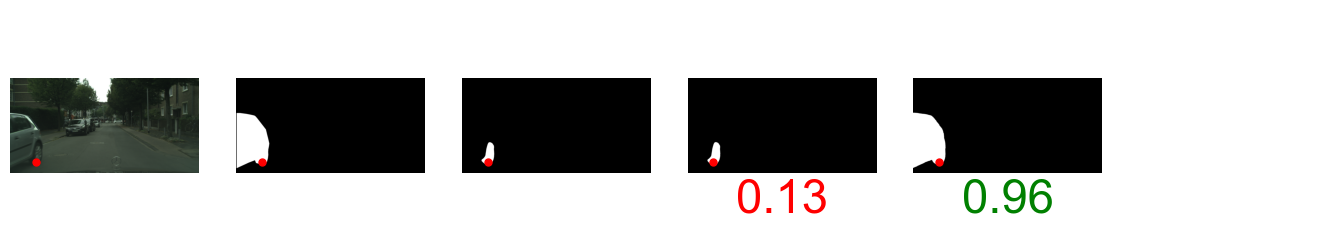

In [28]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=34)
plt.rc('axes', titlesize=34)     
plt.rc('axes', labelsize=34)
plt.rc('figure', titlesize=34)

np.random.seed(3)

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(17, 3))

i=0
for index, row in results_table_test.sample(n=1).iterrows():
    image_number = row["image_number"]
    coord = row["coord"]
    coord = (coord[0].item(), coord[1].item())
    T_confidence_set_duplicates_removed = T_confidence_set[row["Final Mask Indices"]]
    print(image_number)
    print(coord)
    
    img = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_leftImg8bit.png'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.sca(axs[0])
    plt.axis('off')
    plt.imshow(img)
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    
    #print("True Segmentation")
    true_segmentation = cv2.imread(os.path.join('data/cityscapes/val_200/', image_number+'_gtFine_instanceIds.png'), cv2.IMREAD_UNCHANGED)
    plt.sca(axs[1])
    plt.axis('off')
    plt.imshow(true_segmentation==true_segmentation[coord], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)

    masks, scores = segment_anything_predict(img, np.array([[coord[1], coord[0]]]))
    masks_ordered = masks[np.argsort(scores)[::-1]]

    #print("Baseline Model Prediction")
    T = 50
    T1 = int(np.floor(T/100))
    T2 = (T % 100)/100
    baseline_segmentation = masks_ordered[T1]>T2
    plt.sca(axs[2])
    plt.imshow(baseline_segmentation==baseline_segmentation[coord], cmap='gray')
    plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
    plt.axis('off')

    #print("Confidence Set with Duplicates Removed")
    true_shape = true_segmentation==true_segmentation[coord]
    for j, T in enumerate(T_confidence_set_duplicates_removed):
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        pred_segmentation = masks_ordered[T1]>T2
        IOU = iou(torch.from_numpy(true_shape), torch.from_numpy(pred_segmentation)).numpy().item()
        
        plt.sca(axs[3+j])
        #plt.axis('off')
        plt.imshow(pred_segmentation, cmap='gray')
        plt.plot(coord[1], coord[0], "o", color="red", markersize=5)
        #plt.title(f"{np.round(IOU, 2):.2f}", y=-0.5)

        ax = plt.gca()
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)

        T= T_confidence_set_duplicates_removed[j]
        T1 = int(np.floor(T/100))
        T2 = (T % 100)/100
        #plt.title(f"T=({T1+1}, {T2})")

        if IOU > tau:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='green')
        else:
            plt.xlabel(f"{np.round(IOU, 2):.2f}", color='red')

    # remove empty grids
    for j in range(3+len(T_confidence_set_duplicates_removed), 6):
        axs[j].axis('off')

    i += 1

#plt.tight_layout()
plt.savefig('plots/vehicle-detection-single-example.png', dpi=300, bbox_inches='tight')
plt.show()

In [36]:
plt.rcParams["font.sans-serif"] = "Arial"

plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.bar(results_table_test['Final Mask Number'].value_counts().index, results_table_test['Final Mask Number'].value_counts().values/len(results_table_test))
plt.xticks(np.arange(1, 4))
plt.ylim([0, 1])
plt.xlabel("Number of Masks")
plt.ylabel("Relative Frequency")
plt.show()

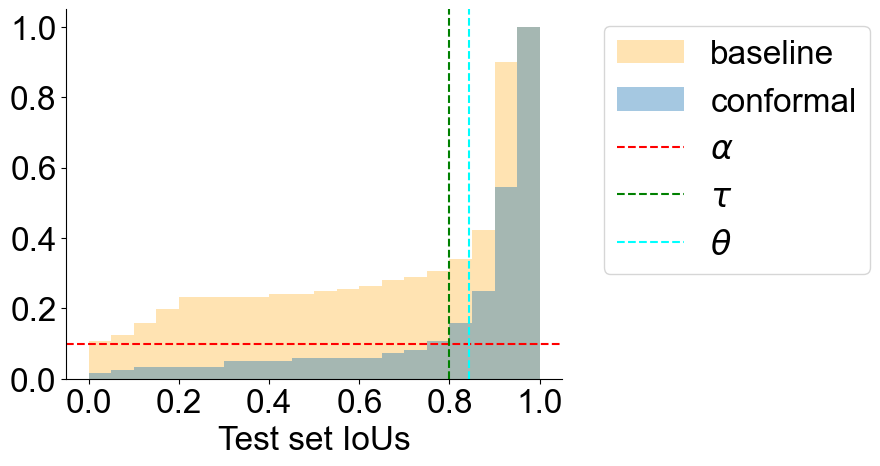

In [11]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

file = open('data/cityscapes/conformal_ious_test_baseline_SAM.pkl', 'rb')
results_table_baseline = pickle.load(file)
file.close()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(results_table_baseline["IOUs"].apply(lambda x: x[0]), bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.3, label='baseline', color='orange')
plt.hist(results_table_test["Final Mask max IOU"], bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.4, label='conformal')
plt.xlabel("Test set IoUs")
#plt.ylabel("Cumulative Frequency")
plt.xticks(np.arange(0, 1.01, 0.2))
plt.yticks(np.arange(0, 1.01, 0.2))
plt.axhline(alpha, color='red', linestyle='dashed', label=r'$\alpha$')
plt.axvline(tau, color='green', linestyle='dashed', label=r'$\tau$')
plt.axvline(q, color='cyan', linestyle='dashed', label=r'$\theta$')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()

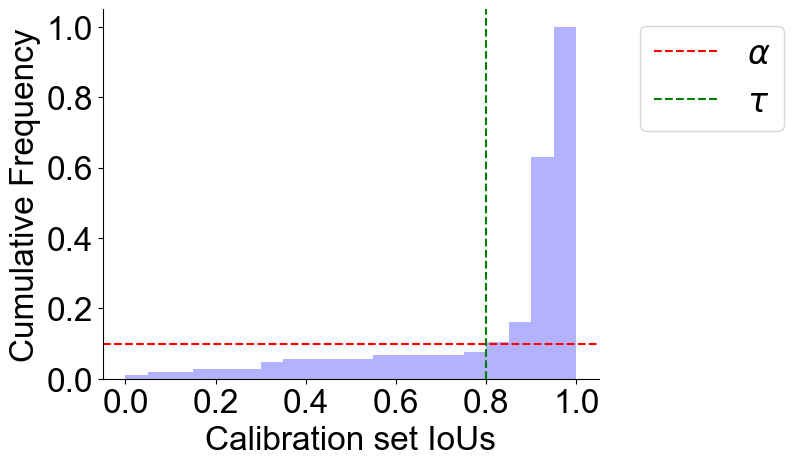

In [12]:
plt.rcParams["font.sans-serif"] = "Arial"
plt.rc('font', size=24)          
plt.rc('axes', titlesize=24)     
plt.rc('axes', labelsize=24)    
plt.rc('xtick', labelsize=24)    
plt.rc('ytick', labelsize=24)    
plt.rc('figure', titlesize=24)

file = open('data/cityscapes/conformal_ious_SAM.pkl', 'rb')
results_table_calibration = pickle.load(file)
file.close()

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.hist(results_table_calibration["IOUs"].map(lambda x: np.max(x)), bins=np.arange(0, 1.01, .05), density=True, cumulative=True, alpha=0.3, color='blue')
plt.xlabel("Calibration set IoUs")
plt.ylabel("Cumulative Frequency")
plt.xticks(np.arange(0, 1.01, 0.2))
plt.yticks(np.arange(0, 1.01, 0.2))
plt.axhline(alpha, color='red', linestyle='dashed', label=r'$\alpha$')
plt.axvline(tau, color='green', linestyle='dashed', label=r'$\tau$')
plt.legend(bbox_to_anchor=(1.05, 1))

plt.show()